1. time series data need to be stationary for proper analysis, Will need to analysis it for EACH product and train a different model for each product
2. Data seems insufficient for timeseries if I break it down to Plant-SKU level (yet need to take a deeper dive) If i were to look monthly, it is 12*2 per SKU. If it is a high-seller, I maybe able to break it down into week level, 52*2*12 and hope that there is a trend.
3. 5 different Xgboost model to predict qty and 1 ensemble model to softmax them

### Setup

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display as dis

pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns = 30

**Data**

In [5]:
df = pd.read_excel('./Data/2017 - 2019 YTD Order Volume_v2.xlsx', sheet_name = "Raw Data")

In [6]:
df_copy = df.copy() #saving up a copy of original df just in case might have to overwrite.

####  Taking a peak 

In [7]:
print('Number of rows: {}'.format(df.shape[0]))
print('Number of features: {}'.format(df.shape[1]))

Number of rows: 588313
Number of features: 32


In [8]:
df.dtypes[:10]

Actual Goods Issue Year Period    object
Sold-to party                      int64
Sold to Party Name                object
Customer Hierarchy                object
Ship-to party                      int64
Ship to Party Name                object
Location (City)                   object
Region                            object
Region Name                       object
Postal Code                       object
dtype: object

# ------------------------------------------ Fix Data -----------------------------------------------

In [9]:
# Changing Data Type as STR and Column type as Object
df.loc[:,"Actual Goods Issue Year Period":"Description"] = df.loc[:,"Actual Goods Issue Year Period":"Description"].astype(object)
df.iloc[:,0:27] = df.iloc[:,0:27].applymap(str)

Replace  wrong/vague inputs from the SAP <br>
**Need to change EDI mapping in the future**

In [10]:
df

,Actual Goods Issue Year Period,Sold-to party,Sold to Party Name,Customer Hierarchy,Ship-to party,Ship to Party Name,Location (City),Region,Region Name,Postal Code,Sales Org,Sales Org. Name,Distr Chan,Distr. Channel Name,Division,...,Document date,Plant,Plant Name,Postal Code.1,Location (City).1,Region.1,Region Plant Name,Del No.,Material,Description,Order qty,Gds mvt qty,Gross weight ord (Lb),Gross Weight Dlvrd (Lb),GSV Delivered
0,2017P01,10051885,Butterfield & Vallis,nan,10262818,Butterfield & Vallis,Salem,NJ,New Jersey,08079,145,MFI International,10,Non Specific,57,...,20170116,USC8,Hazleton PA DFC - Food,18202,Hazle Township,PA,Pennsylvania,5600991661,U0100504,UB CONVERTED BRAND RICE 6/5LB,189,189,5925.10,5925.10,5367.60
1,2017P01,10051885,Butterfield & Vallis,nan,10262818,Butterfield & Vallis,Salem,NJ,New Jersey,08079,145,MFI International,10,Non Specific,57,...,20170116,USC8,Hazleton PA DFC - Food,18202,Hazle Township,PA,Pennsylvania,5600991661,U0100803,UB CONVERTED BRAND RICE 18/2LB,80,80,3132.33,3132.33,3130.40
2,2017P01,10051885,Butterfield & Vallis,nan,10262818,Butterfield & Vallis,Salem,NJ,New Jersey,08079,145,MFI International,10,Non Specific,57,...,20170116,USC8,Hazleton PA DFC - Food,18202,Hazle Township,PA,Pennsylvania,5600991661,U0103102,UB CONVERTED BRAND RICE 12/1LB,90,90,1192.48,1192.48,1203.30
3,2017P01,10051885,Butterfield & Vallis,nan,10262818,Butterfield & Vallis,Salem,NJ,New Jersey,08079,145,MFI International,10,Non Specific,57,...,20170116,USC8,Hazleton PA DFC - Food,18202,Hazle Township,PA,Pennsylvania,5600991661,U1100102,UB WHOLE GRAIN BROWN RICE 12/1LB,50,50,662.49,662.49,726.50
4,2017P01,10051885,Butterfield & Vallis,nan,10262818,Butterfield & Vallis,Salem,NJ,New Jersey,08079,145,MFI International,10,Non Specific,57,...,20170116,USC8,Hazleton PA DFC - Food,18202,Hazle Township,PA,Pennsylvania,5600991661,U1200702,UB BRAND BROWN RICE 12/2LB,45,45,1142.88,1142.88,1239.75
5,2017P01,10051885,Butterfield & Vallis,nan,10262818,Butterfield & Vallis,Salem,NJ,New Jersey,08079,145,MFI International,10,Non Specific,57,...,20170103,USC8,Hazleton PA DFC - Food,18202,Hazle Township,PA,Pennsylvania,5600978762,10134161,UB COUNTRY INN CHICKEN RICE 12/5oz,75,75,350.20,350.20,864.00
6,2017P01,10051885,Butterfield & Vallis,nan,10262818,Butterfield & Vallis,Salem,NJ,New Jersey,08079,145,MFI International,10,Non Specific,57,...,20170103,USC8,Hazleton PA DFC - Food,18202,Hazle Township,PA,Pennsylvania,5600978762,10134170,UB COUNTRY INN CHICKEN & BROCCOLI 12/5oz,25,25,115.74,115.74,288.00
7,2017P01,10051885,Butterfield & Vallis,nan,10262818,Butterfield & Vallis,Salem,NJ,New Jersey,08079,145,MFI International,10,Non Specific,57,...,20170103,USC8,Hazleton PA DFC - Food,18202,Hazle Township,PA,Pennsylvania,5600978762,10134172,UB COUNTRY INN CHICKEN & VEG RICE 12/5oz,25,25,117.51,117.51,288.00
8,2017P01,10051885,Butterfield & Vallis,nan,10262818,Butterfield & Vallis,Salem,NJ,New Jersey,08079,145,MFI International,10,Non Specific,57,...,20170103,USC8,Hazleton PA DFC - Food,18202,Hazle Township,PA,Pennsylvania,5600978762,U0100504,UB CONVERTED BRAND RICE 6/5LB,21,21,658.34,658.34,596.40
9,2017P01,10051885,Butterfield & Vallis,nan,10262818,Butterfield & Vallis,Salem,NJ,New Jersey,08079,145,MFI International,10,Non Specific,57,...,20170103,USC8,Hazleton PA DFC - Food,18202,Hazle Township,PA,Pennsylvania,5600978762,U0103102,UB CONVERTED BRAND RICE 12/1LB,130,130,1722.47,1722.47,1738.10


In [11]:
# Fixing City: 01810(zip) to Andover
df['Location (City)'].replace('01810', 'Andover', inplace=True) 

# Fixing Region: at Chicago (# to IL)
temp = df['Sold-to party'] == '10263014' 
df.loc[temp,'Region'] = df.loc[temp,'Region'].replace('#', 'IL')  

For my own clarification Region = 01 and 02 is all for US Virgin Island

In [12]:
# 01,02 to USVI. For clarification
df.replace({'Region':{'01':'USVI','02':'USVI'}},inplace=True) 

# 1) Basic understanding of the business

Get the size of the business per region by distribution center

In [13]:
group0 = df.groupby(['Region.1','Plant'])

colFunc = {'Sold-to party':['nunique'],
           'Material':['nunique'],
           'Del No.':['nunique','count'],
           'Order qty':['sum']        
          }

analysis = group0.agg(colFunc)
analysis

Sold-to party Material Del No.         Order qty
                     nunique  nunique nunique   count       sum
Region.1 Plant                                                 
CA       USD3             57      135    3988   44080   3435293
GA       USE2             56      139    3955   54831   4254287
IL       USC9             41      129    2448   34590   1984211
         USV2             29      114     777   12574    982164
MS       USJ7            126      249   36643  339971  29620771
PA       USC8             56      158    5403   80733   8177169
TX       USD2             31      103    1413   19192    817608
         USV6             21       87     215    2342    232919

#### Understanding: 
- **USC9 and USV6 not found on DC master on XL sheet. For IL and TX, looks like there has been DC transition over time**
- MS ships most of the products
- Looks as if we have not used UV2 (Nebraska) and UV6 (Colorado) over years

#### Q1. was there was a WH transition
#### Q2. do we not use UV2, UV6

# 2) Figuring out which Plant  I should go by... 

In [14]:
# Converting Date type
from datetime import datetime as dt
df['Document date'] = df['Document date'].apply(lambda x: dt.strptime(x, '%Y%m%d'))

Get min, max avg of Date Time

In [15]:
print("Earliest date of USD2: {}" .format(df.loc[df['Plant'] == 'USC9','Document date'].min()))
print("Latest date of USD2: {}" .format(df.loc[df['Plant'] == 'USC9','Document date'].max()))
print("-"*50)
print("Earliest date of USV6: {}" .format(df.loc[df['Plant'] == 'USV6','Document date'].min()))
print("Latest date of USV6: {}" .format(df.loc[df['Plant'] == 'USV6','Document date'].max()))

Earliest date of USD2: 2016-08-29 00:00:00
Latest date of USD2: 2019-08-15 00:00:00
--------------------------------------------------
Earliest date of USV6: 2019-05-22 00:00:00
Latest date of USV6: 2019-09-03 00:00:00


In [16]:
print("USD2 avg GI time: {}".format(pd.to_datetime(pd.to_datetime(df.loc[df['Plant'] == 'USD2','Document date']).values.astype(np.int64).mean())))
print("USV6 avg GI time: {}".format(pd.to_datetime(pd.to_datetime(df.loc[df['Plant'] == 'USV6','Document date']).values.astype(np.int64).mean())))
print("-"*50)
print("USC9 avg GI time: {}".format(pd.to_datetime(pd.to_datetime(df.loc[df['Plant'] == 'USC9','Document date']).values.astype(np.int64).mean())))
print("USV2 avg GI time: {}".format(pd.to_datetime(pd.to_datetime(df.loc[df['Plant'] == 'USV2','Document date']).values.astype(np.int64).mean())))

USD2 avg GI time: 2018-03-25 10:30:38.265944320
USV6 avg GI time: 2019-07-17 07:25:09.479077632
--------------------------------------------------
USC9 avg GI time: 2018-01-17 12:57:32.003468800
USV2 avg GI time: 2019-05-08 17:29:01.307459840


Seems as if **USD2 has transitioned to USV6** therefore we combine them to **USV6** for IL<br>
Seems as if **USC9 has transitioned to USV2** therefore we combine them to **USV2** for TX


#### Fix Plant and re-run above

In [17]:
# Fixing: Plant 
df['Plant'].replace('USD2', 'USV6', inplace=True)
df['Plant'].replace('USC9', 'USV2', inplace=True) 

In [18]:
group0 = df.groupby(['Region.1','Plant'])

colFunc = {'Sold-to party':['nunique'],
           'Material':['nunique'],
           'Del No.':['nunique','count'],
           'Order qty':['sum']        
          }

analysis = group0.agg(colFunc)
analysis['rate'] = analysis['Order qty']/analysis['Order qty'].sum()
dis.display(analysis)

Sold-to party Material Del No.         Order qty rate
                     nunique  nunique nunique   count       sum     
Region.1 Plant                                                      
CA       USD3             57      135    3988   44080   3435293 0.07
GA       USE2             56      139    3955   54831   4254287 0.09
IL       USV2             42      161    3225   47164   2966375 0.06
MS       USJ7            126      249   36643  339971  29620771 0.60
PA       USC8             56      158    5403   80733   8177169 0.17
TX       USV6             36      116    1628   21534   1050527 0.02

**MS: USJ7 holds the 60% of the business**

Creating Year, Month, Week columns for future analysis

In [19]:
df['DD_week_num'] = df['Document date'].dt.week # week_num
df['DD_month'] = df['Document date'].dt.month # month
df['DD_year'] = df['Document date'].dt.year # year

# 3) Distribution Center Master

In [20]:
dcdf = pd.read_excel('./Data/2017 - 2019 YTD Order Volume_v2.xlsx', sheet_name = "DC and State")

**Below is the State per DC mapping Master**

In [21]:
dis.display(pd.pivot_table(dcdf, index=['DC','State'], aggfunc=np.sum))

Abbreviation
DC   State                      
USC8 Connecticut              CT
     Delaware                 DE
     Maine                    ME
     Massachusetts            MA
     New Hampshire            NH
     New Jersey               NJ
     New York                 NY
     Pennsylvania             PA
     Rhode Island             RI
     Vermont                  VT
USD3 Alaska                   AK
     California               CA
     Hawaii                   HI
     Idaho                    ID
     Nevada                   NV
     Oregon                   OR
     Washington               WA
USE2 Alabama                  AL
     Florida                  FL
     Georgia                  GA
     Maryland                 MD
     Mississippi              MS
     North Carolina           NC
     South Carolina           SC
     Tennessee                TN
     Virginia                 VA
     West Virginia            WV
USV2 Illinois                 IL
     Indiana                  IN
     Iowa                     IA
     Kentucky                 KY
     Michigan                 MI
     Minnesota                MN
     Montana                  MT
     North Dakota             ND
     Ohio                     OH
     South Dakota             SD
     Wisconsin                WI
     Wyoming                  WY
USV6 Arizona                  AZ
     Arkansas                 AR
     Kansas                   KS
     Louisiana                LA
     Missouri                 MO
     New Mexico               NM
     Oklahoma                 OK
     Texas                    TX
     Utah                     UT
UV2  Nebraska                 NE
UV6  Colorado                 CO

Merge DC mapping to the original DF

In [22]:
# merging correct DC by actual_region on the dataframe
dcdf = dcdf.drop('State', axis=1)
df = df.merge(dcdf, left_on = 'Region', right_on = 'Abbreviation', how='left').drop('Abbreviation', axis=1)

ANY NULL VALUES?

In [23]:
# checking null values and there are 1931 NULL
df.isna().sum(axis=0).sort_values(ascending=False)

DC                                1931
DD_year                              0
Division Name                        0
Division                             0
Distr. Channel Name                  0
Distr Chan                           0
Sales Org. Name                      0
Sales Org                            0
Postal Code                          0
Region Name                          0
Region                               0
Location (City)                      0
Ship to Party Name                   0
Ship-to party                        0
Customer Hierarchy                   0
Sold to Party Name                   0
Sold-to party                        0
Sales document                       0
Document date                        0
Plant                                0
Order qty                            0
DD_month                             0
DD_week_num                          0
GSV Delivered                        0
Gross Weight Dlvrd (Lb)              0
Gross weight ord (Lb)    

# Q3: Where should we ship out of US orders from

The 1931 NULL values are from out side of US.

In [24]:
dc_result = df[df.isna().any(axis=1)].groupby(['Region','Plant','Region.1'])[['Del No.']].count().reset_index()
dc_result

,Region,Plant,Region.1,Del No.
0,#,USE2,GA,92
1,#,USJ7,MS,818
2,ON,USJ7,MS,629
3,ON,USV2,IL,22
4,USVI,USE2,GA,370


# 3-1) Orders out of US to fix

**Out of US List:**
    - Ontario
    - US Virgin Island
    - #: being somea other countries like Trinidad or Pueto Rico.. etc

**Since we do not have State-DC map for the Out of US orders.. <br> I'll just assume with the most frequent deliveries from the past**

In [25]:
# adding percentage city level
dc_result = df[df.isna().any(axis=1)].groupby(['Region','Plant','Region.1','Location (City)'])[['Del No.']].count().reset_index()
temp = dc_result.groupby(['Location (City)'])[['Del No.']].apply(lambda x: x/x.sum()).rename(columns={"Del No.": "Del % by City"})
pd.concat([dc_result, temp], axis=1).sort_values(by=['Location (City)'])

,Region,Plant,Region.1,Location (City),Del No.,Del % by City
0,#,USE2,GA,Barbados,8,0.42
5,#,USJ7,MS,Barbados,11,0.58
6,#,USJ7,MS,CEDAR RAPIDS,1,1.00
7,#,USJ7,MS,JEDDAH,646,1.00
1,#,USE2,GA,Nassau,53,0.37
8,#,USJ7,MS,Nassau,91,0.63
2,#,USE2,GA,Pompano Beach,12,1.00
3,#,USE2,GA,St. Catherine,12,0.38
9,#,USJ7,MS,St. Catherine,20,0.62
13,USVI,USE2,GA,St. Croix,183,1.00



### Below is just purely an assumption using where they have shipped out in the past.
***Orders from:*** <br>
**#:**
- Barbados: USJ7
- CEDAR RAPIDS: USJ7
- JEDDAH: USJ7
- Nassau: USJ7
- St.Catherine: USJ7
- Trinidad: USJ7
<br><br>
- Pompano Beach: USE2

------------------------
**USVI:**
- St. Croix: USE2
- St. Thomas: USE2

--------------------------
**ON:**
- TORONTO: USJ7

In [26]:
### FILL IN NA
temp = (df['Region']=='#') & (df['Location (City)'] != 'Pompano Beach')
df.loc[temp,'DC'] = df[temp]['DC'].fillna('USJ7')
temp = (df['Region']=='#') & (df['Location (City)'] == 'Pompano Beach')
df.loc[temp,'DC'] = df[temp]['DC'].fillna('USE2')

temp = df['Region'] == 'USVI'
df.loc[temp,'DC'] = df[temp]['DC'].fillna('USE2')

temp = df['Location (City)'] == 'TORONTO'
df.loc[temp,'DC'] = df[temp]['DC'].fillna('USJ7')

# 4) Hierarchy and Priority

In [27]:
hpdf = pd.read_excel('./Data/2017 - 2019 YTD Order Volume_v2.xlsx', sheet_name = "Customer Hierarchy")
# change sold-to-party to str
hpdf.iloc[:,0] = hpdf.iloc[:,0].apply(lambda x: str(x))
# merge Parent Account and Priority for Future refernce
df = df.merge(hpdf, left_on = 'Sold-to party', right_on = 'Sold-to party', how='left').drop('Sold To Name', axis=1)
# Number of NAs
df.isna().sum().sort_values(ascending = False)[:2]

Priority          2389
Parent Account    1357
dtype: int64

# --------------------------------------------------- Analysis ----------------------------------------------

# 1) Visualize Trend

**Overall trend of Mars Food (week)**

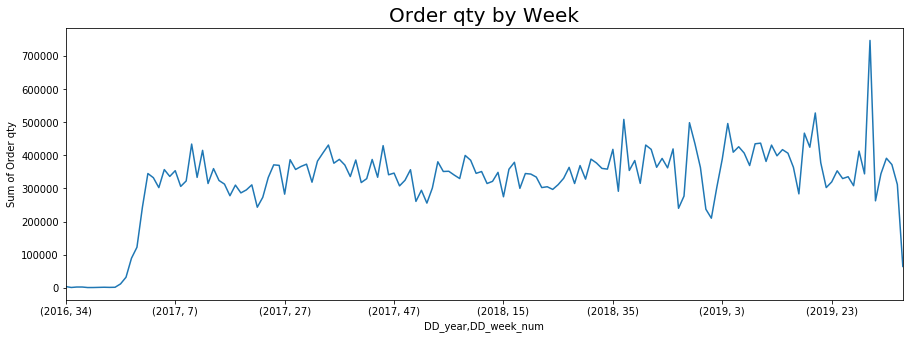

In [28]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
df.groupby(['DD_year','DD_week_num'])['Order qty'].sum().plot()
plt.title('Order qty by Week', size=20)
plt.ylabel('Sum of Order qty', size=10)
plt.show()

**Overall trend of Mars Food (month)**

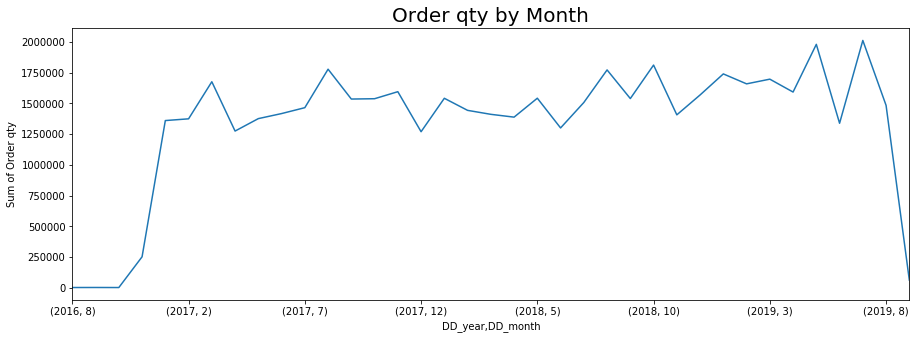

In [29]:
df.groupby(['DD_year','DD_month'])['Order qty'].sum().plot()
plt.title('Order qty by Month', size=20)
plt.ylabel('Sum of Order qty', size=10)
plt.show()

**Is there a trend per WH?**

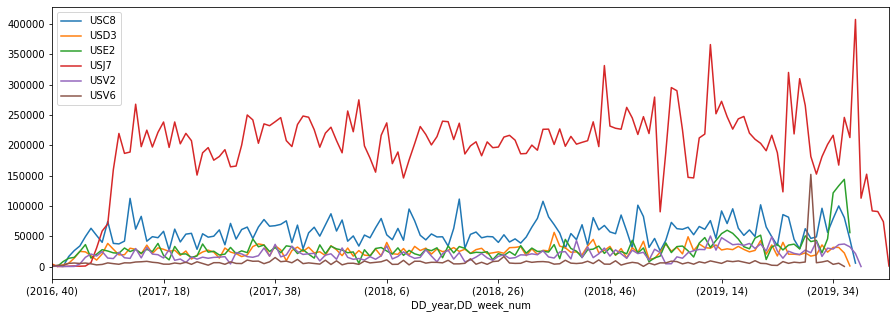

In [30]:
for index, group in df.groupby(['Plant']):
    group_agg = group.groupby(['DD_year','DD_week_num'])['Order qty'].sum()
    group_agg.plot(y='Quantity', label=index, legend=True)

# 1) Checking if we are shipping correctly: IGNORING THE EXCEPTION

***Before we had into the analysis below is the list of Plants with corresponding States***

In [31]:
DC_df = pd.DataFrame({'Plant': df['Plant'].unique().tolist(), 'State_DC': df['Region.1'].unique().tolist()})
DC_df = DC_df.append(pd.DataFrame({'Plant':['UV6','UV2'], 'State_DC':['CO','NE'] })).reset_index(drop=True)
DC_df

,Plant,State_DC
0,USC8,PA
1,USJ7,MS
2,USE2,GA
3,USV2,IL
4,USV6,TX
5,USD3,CA
6,UV6,CO
7,UV2,NE


Make correct DC column

In [32]:
df['Correct_DC'] = (df['Plant'] == df['DC'])

###### Orders from Texas

In [33]:
df.loc[df['Region']=='TX']['Plant'].value_counts()

USJ7    39658
USV6    14461
USE2      624
USD3      149
Name: Plant, dtype: int64

In [34]:
df.loc[df['Region']=='TX']['Correct_DC'].mean()

0.2634445820884646

Even so Texas is one of the state has a DC, only 26% of shipments has shipped out from TX. <br>
Knowing that we have ignored the exception, it doesn't look good.

# 1-a) Occurence for all over the states

In [35]:
plt.rcParams["figure.figsize"] = (15,10)

In [36]:
check_dc = df.groupby(['Region','Correct_DC']).size().unstack().fillna(0)\
        .reset_index().rename(columns={True: "True", False: "False"}) \
        .set_index('Region')

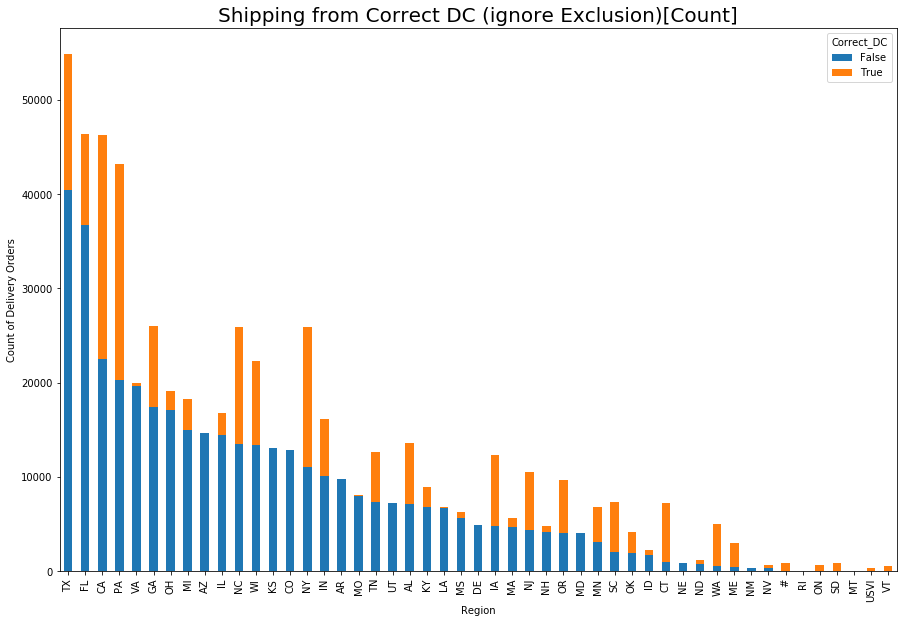

In [37]:
check_dc.sort_values(by='False',ascending=False).plot(kind='bar', stacked=True)
plt.title('Shipping from Correct DC (ignore Exclusion)[Count]', size=20)
plt.ylabel('Count of Delivery Orders')
plt.show()

**~67% of orders are not shipped from correct DC**

# Q5 What is the reason behind the having the Exceptions and ship so many orders from far across the country

In [38]:
df['Correct_DC'].value_counts()/df['Correct_DC'].count()

False   0.67
True    0.33
Name: Correct_DC, dtype: float64

## Information:
VERY bad result...
# Q
- Need to ask if we do ***shipped complete*** orders <br>
- Ask for most recent DC-State mapping.
- Idealy it is best to do Zip-Code DC mapping...

# 1-b) Running above including Exceptions


### Exception:

- Smart & Final Sold To ships from USJ7
- Costco ships 100% for USJ7
- BJs ships 100% from USJ7
- Sam's Ships 100% from USJ7
<br>
- need to ask if Walmart is considered Sam's because ALL of Wal-mart orders have been shipped from MS

# Q6 Is Wal-mart part of Sam's shipments

In [39]:
sold_to_party_Exception = ['10193987','10196383','10197632','10197635','10198140','10245298','10245713',\
                           '10245932','10246586','10246645','10246774','10246885','10205201','10202571',\
                           '10193387','10197634','10205184','10195564','10429897','10195174','10195459',\
                           '10197519','10198228','10199067','10198392','10246105','10196037','10263014',\
                           '10200260','10267941','10193759','10194260','10202144','10336077','10246235',\
                           '10192687','10194593','10202194','10334798','10194021','10401878'                        
                          ]


In [40]:
# Changing to USJ7 for the exceptions
df.loc[df['Sold-to party'].apply(lambda x: True if x in sold_to_party_Exception else False),'DC'] = 'USJ7'

In [41]:
# Update Correct_DC Column
df['Correct_DC'] = (df['Plant'] == df['DC'])

In [42]:
check_dc = df.groupby(['Region','Correct_DC']).size().unstack().fillna(0)\
        .reset_index().rename(columns={True: "True", False: "False"}) \
        .set_index('Region')

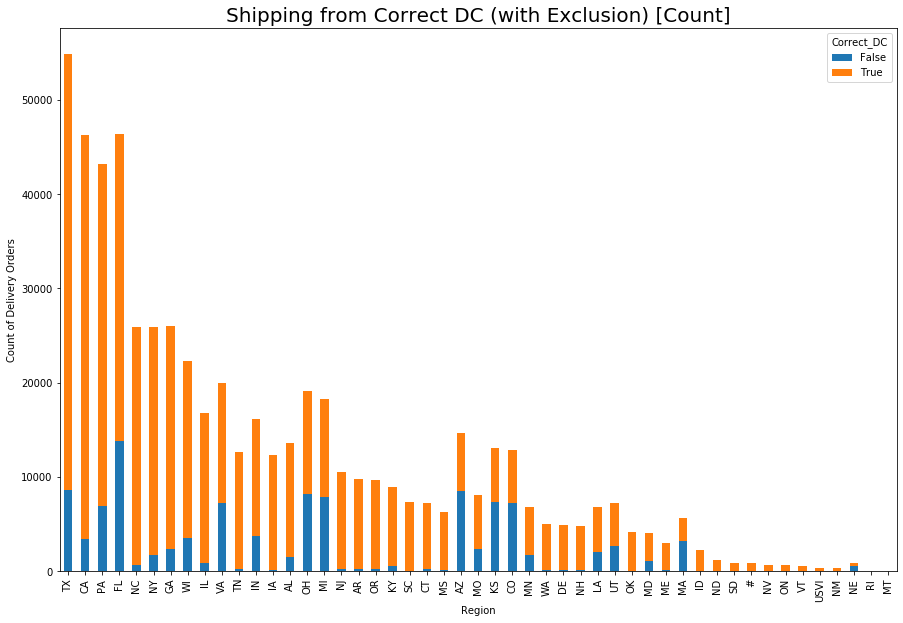

In [43]:
check_dc.sort_values(by='True',ascending=False).plot(kind='bar', stacked=True)
plt.title('Shipping from Correct DC (with Exclusion) [Count]', size=20)
plt.ylabel('Count of Delivery Orders', size=10)
plt.show()

**Much better than before**

Above is count of Deliver Orders.
Below will be sum of order qty per WH

# 2-a) Running above at Plant Level

In [44]:
# simple function call for total and rate column on pivots
def totNrate(df):
    df['Total'] = df[False]+df[True]
    df['Rate'] = df[True] / (df[False] + df[True])
    return df

In [45]:
TF_rate_df = df.pivot_table(values='Order qty', index='DC', columns='Correct_DC', aggfunc = lambda x: x.sum()).fillna(0)
TF_rate_df = totNrate(TF_rate_df)
TF_rate_df = TF_rate_df.sort_values(by='Rate', ascending = False)  # Sort
TF_rate_df = TF_rate_df.merge(DC_df, left_on = 'DC', right_on = 'Plant', how = 'left') # merge State

In [46]:
check_dc = df.groupby(['Region','Correct_DC']).size().unstack().fillna(0)\
        .reset_index().rename(columns={True: "True", False: "False"}) \
        .set_index('Region')

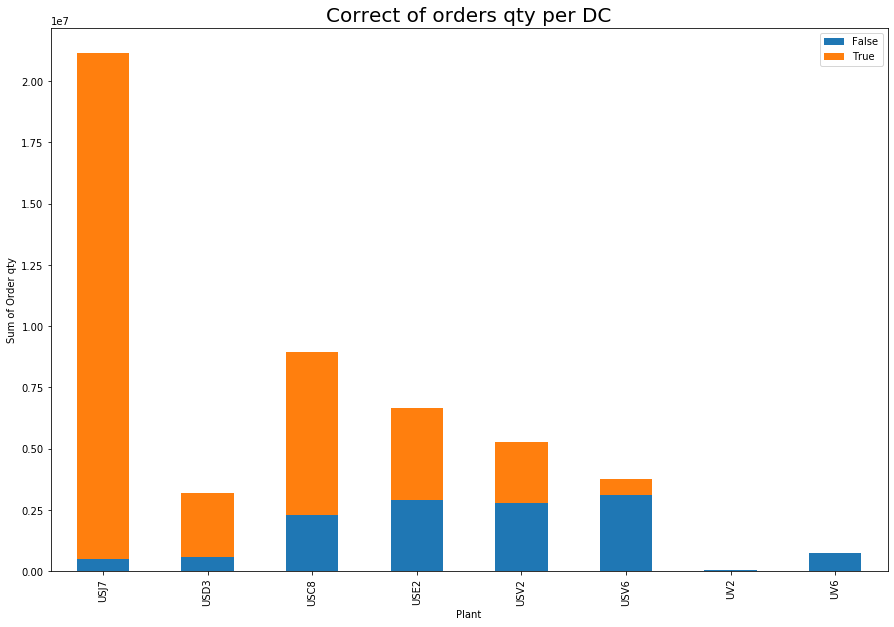

In [47]:
TF_rate_df.rename(columns={True: "True", False: "False"})[['False','True','Plant']].set_index('Plant').plot(kind='bar', stacked=True)
plt.title('Correct of orders qty per DC', size=20)
plt.ylabel('Sum of Order qty', size=10)
plt.show()

-------------------------------------------------------------
**Information**: <br>
PA, GA, IL, TX, NE, CO needs to be taken a look at (below 80%)

# Vendor

## 2-b) is any other possible Exception Vendors that we are not aware?

Check if there exists other noticeable Sold to Parties

In [48]:
TF_s2p_df = df.pivot_table(values='Region', index='Sold to Party Name', columns='Correct_DC', aggfunc = lambda x: x.count()).fillna(0)
TF_s2p_df = totNrate(TF_s2p_df)

**CONDITION:** For any SOLD_TO_PARTY with Delivery Order Count >=20, sort Descending

In [49]:
TF_s2p_df[TF_s2p_df[False]>=20].sort_values(by=['Total'], ascending = False).sort_values(by=['Rate'], ascending = True)

Correct_DC,False,True,Total,Rate
Sold to Party Name,,,,
ALBERTSONS INTERMOUNTAIN (POI),736.00,0.00,736.00,0.00
MID-MOUNTAIN FOODS INC (POI),891.00,0.00,891.00,0.00
SAFEWAY DENVER (POI),642.00,0.00,642.00,0.00
DILLON STORES (POI),1072.00,0.00,1072.00,0.00
ASSOCIATED FOOD STORES (POI),613.00,0.00,613.00,0.00
MARCS (POI),530.00,0.00,530.00,0.00
H E BUTT GROC CO,5408.00,0.00,5408.00,0.00
BASHAS DISTR CENTER,422.00,0.00,422.00,0.00
SAFEWAY PHOENIX (POI),368.00,0.00,368.00,0.00


#### There maybe some extra sold-to-party that we are not much aware of that are.

# Q7. Are there other Vendors that should be included in the exception?

Vendor by Plant Level Pivot

In [50]:
 df[df['Sold to Party Name'].isin(TF_s2p_df[TF_s2p_df['Rate']<=0.2].index.tolist())].groupby(['Sold to Party Name','Plant'])[['Plant']].count()

Plant
Sold to Party Name              Plant       
ALBERTSONS ACME (POI)           USC8     355
                                USJ7    2100
ALBERTSONS INTERMOUNTAIN (POI)  USD3     715
                                USJ7      21
ALBERTSONS SOUTHWEST (TOLLESON) USD3    2163
                                USJ7     156
AMERICAN SEAWAY FOODS (POI)     USC8    2377
                                USJ7      49
ASSOCIATED FOOD STORES (POI)    USD3     613
ASSOCIATED GROCERS INC (POI)    USE2     347
ATLANTIC FOOD & SPICES          USJ7       2
BASHAS DISTR CENTER             USD3     422
DEMOULAS SUPERMARKET            USC8     659
                                USJ7    3191
DILLON STORES (POI)             USJ7      40
                                USV2     731
                                USV6     301
DPI SPECIALTY FOOD INC          USC8      18
                                USJ7       1
FOOD LION (POI)                 USC8     500
                                USJ7    3293
                                USV2      16
FRY'S FOOD STORES (POI)         USD3    1369
                                USJ7     133
GLOBAL TRADING ENTERPRISES LLC  USJ7       1
GROCERY OUTLET 97               USC8       8
                                USD3       7
                                USE2       2
                                USJ7      68
                                USV2       8
...                                      ...
KRASDALE FOODS INC              USJ7    1016
LAUREL GROCERY CO (POI)         USE2     173
MARCS (POI)                     USC8      96
                                USJ7     434
MEIJER (POI)                    USC8   14624
                                USJ7     142
                                USV2      95
MID-MOUNTAIN FOODS INC (POI)    USC8     891
PRICE SMART INC                 USJ7      14
PUBLIX                          USC8       1
                                USE2    2517
                                USJ7   14790
PUBLIX ATLANTA                  USE2     427
                                USJ7    2179
RALPHS GROCERY CO (POI)         USD3     133
                                USJ7    2540
SAFEWAY DENVER (POI)            USD3      17
                                USJ7       8
                                USV6     617
SAFEWAY PHOENIX (POI)           USD3     354
                                USJ7      14
SAFEWAY, INC 6551               USJ7     147
SCHNUCKS MARKET                 USJ7      34
                                USV2    1603
                                USV6       1
THE KROGER SOUTHWEST            USD3       1
                                USJ7    2347
                                USV6       5
THE NORTH WEST COMPANY INTL     USJ7      10
The Hara Agencies               USJ7       1

[72 rows x 1 columns]

## 2-c) Is there any other vendor who bought less than 5 occurence?

In [51]:
return_ = df.drop_duplicates(subset ="Del No.", keep = False) 
return_ = return_.groupby('Sold-to party').filter(lambda x: len(x) <= 5)['Sold-to party'].unique()

In [52]:
df[df['Sold-to party'].isin(return_)]['Sold to Party Name'].unique()

array(['Butterfield & Vallis', 'L.J. Williams Limited',
       'Martijn Trading Co., Ltd.', 'DPI SPECIALTY FOOD INC',
       'UNIFIED GROCERS SEATTLE POI', 'BROOKSHIRE GROC CO (POI)',
       'WEIS MARKETS (POI)', 'SAFEWAY PHOENIX (POI)',
       'HY VEE FOOD STORES', 'ASSOCIATED GROCERS MIAMI (POI)',
       'ASSOCIATED FOOD STORES (POI)', 'CERTCO INC (POI)',
       'INGLES MARKET (POI)', 'PIGGLY WIGGLY AL DISTR CO(POI)',
       'FOOD LION (POI)', 'STATER BROS MARKET (POI)', 'SHAWS BANNER',
       'HARRIS TEETER (POI)', 'AFFILIATED FOODS INC TX (POI)',
       'C & S CENTRAL (POI)', 'DPI WEST', 'SUPER STORE INDUSTRIES (POI)',
       'WEGMANS FOOD MARKETS (POI)', 'MERCHANTS DISTR INC',
       'UNITED SUPERMARKET (POI)', 'KRASDALE FOODS INC',
       "ROUNDY'S INC (POI)", 'UNIFIED GROCERS SO CAL (POI)',
       'BURRIS LOGISTICS', 'JAMAC FROZEN FOOD CORPORATION',
       'Lightbourn Trading Co. Ltd.', "GELSON'S MARKETS",
       'NOVA FOODS LLC', 'FOODCO DISTRIBUTORS, INC',
       'B O KINNEY D

# 3) DC

## 3-a) CORRECT Rate over time

In [53]:
TF_time_df = df.pivot_table(values='Region', index=['DD_year','DD_month'], columns='Correct_DC', aggfunc = lambda x: x.count()).fillna(0)
TF_time_df = totNrate(TF_time_df)

In [54]:
TF_time_df

Correct_DC        False   True  Total  Rate
DD_year DD_month                           
2016    8             9      1     10  0.10
        10            1     19     20  0.95
        11            1     29     30  0.97
        12          577   2021   2598  0.78
2017    1          3497  14285  17782  0.80
        2          3332  14398  17730  0.81
        3          4026  16566  20592  0.80
        4          2893  13365  16258  0.82
        5          3442  14616  18058  0.81
        6          3206  13379  16585  0.81
        7          3057  13503  16560  0.82
        8          3947  15878  19825  0.80
        9          2553  13518  16071  0.84
        10         3429  13216  16645  0.79
        11         3709  14283  17992  0.79
        12         2873  11721  14594  0.80
2018    1          3928  16056  19984  0.80
        2          3497  14662  18159  0.81
        3          3535  15336  18871  0.81
        4          3572  14925  18497  0.81
        5          4127  17142  21269  0.81
        6          3236  14113  17349  0.81
        7          3814  15480  19294  0.80
        8          3770  17877  21647  0.83
        9          3384  14697  18081  0.81
        10         4107  18021  22128  0.81
        11         3245  13570  16815  0.81
        12         3184  14423  17607  0.82
2019    1          3250  16734  19984  0.84
        2          3693  14799  18492  0.80
        3          2805  16379  19184  0.85
        4          2652  15712  18364  0.86
        5          2962  16041  19003  0.84
        6          1760  13673  15433  0.89
        7          2675  18006  20681  0.87
        8          5991  10799  16790  0.64
        9           817     60    877  0.07

**Mid 80% over 2 years of time**

## 3-b) Site Level Correctness

In [55]:
TF_time_df = df.pivot_table(values='Region', index=['DD_year','DD_month','Plant'], columns='Correct_DC', aggfunc = lambda x: x.count()).fillna(0)
TF_time_df = totNrate(TF_time_df)
dis.display(TF_time_df)

Correct_DC               False     True    Total  Rate
DD_year DD_month Plant                                
2016    8        USJ7     9.00     0.00     9.00  0.00
                 USV2     0.00     1.00     1.00  1.00
        10       USC8     0.00     3.00     3.00  1.00
                 USE2     0.00     2.00     2.00  1.00
                 USJ7     0.00    10.00    10.00  1.00
                 USV2     1.00     3.00     4.00  0.75
                 USV6     0.00     1.00     1.00  1.00
        11       USJ7     1.00    29.00    30.00  0.97
        12       USC8    88.00   327.00   415.00  0.79
                 USD3    47.00   119.00   166.00  0.72
                 USE2    11.00   310.00   321.00  0.97
                 USJ7   364.00  1091.00  1455.00  0.75
                 USV2    49.00   108.00   157.00  0.69
                 USV6    18.00    66.00    84.00  0.79
2017    1        USC8   721.00  1789.00  2510.00  0.71
                 USD3   377.00   950.00  1327.00  0.72
                 USE2    89.00  1699.00  1788.00  0.95
                 USJ7  1924.00  8330.00 10254.00  0.81
                 USV2   282.00  1056.00  1338.00  0.79
                 USV6   104.00   461.00   565.00  0.82
        2        USC8   770.00  1410.00  2180.00  0.65
                 USD3   408.00   985.00  1393.00  0.71
                 USE2    52.00  1427.00  1479.00  0.96
                 USJ7  1750.00  9047.00 10797.00  0.84
                 USV2   214.00  1076.00  1290.00  0.83
                 USV6   138.00   453.00   591.00  0.77
        3        USC8   903.00  1856.00  2759.00  0.67
                 USD3   415.00  1094.00  1509.00  0.72
                 USE2    70.00  1513.00  1583.00  0.96
                 USJ7  2198.00 10337.00 12535.00  0.82
...                        ...      ...      ...   ...
2019    5        USC8   531.00  1602.00  2133.00  0.75
                 USD3   368.00  1057.00  1425.00  0.74
                 USE2    56.00  1454.00  1510.00  0.96
                 USJ7  1605.00 10262.00 11867.00  0.86
                 USV2   287.00  1208.00  1495.00  0.81
                 USV6   115.00   458.00   573.00  0.80
        6        USC8   645.00  1410.00  2055.00  0.69
                 USD3   282.00  1061.00  1343.00  0.79
                 USE2    40.00  1544.00  1584.00  0.97
                 USJ7   433.00  8099.00  8532.00  0.95
                 USV2   272.00  1207.00  1479.00  0.82
                 USV6    88.00   352.00   440.00  0.80
        7        USC8   896.00  1858.00  2754.00  0.67
                 USD3   397.00  1163.00  1560.00  0.75
                 USE2    41.00  2047.00  2088.00  0.98
                 USJ7   486.00 10887.00 11373.00  0.96
                 USV2   401.00  1408.00  1809.00  0.78
                 USV6   454.00   643.00  1097.00  0.59
        8        USC8   739.00  1689.00  2428.00  0.70
                 USD3   382.00  1034.00  1416.00  0.73
                 USE2  3975.00  1656.00  5631.00  0.29
                 USJ7   475.00  4554.00  5029.00  0.91
                 USV2   299.00  1328.00  1627.00  0.82
                 USV6   121.00   538.00   659.00  0.82
        9        USC8    21.00    32.00    53.00  0.60
                 USD3    16.00     0.00    16.00  0.00
                 USE2   780.00     0.00   780.00  0.00
                 USJ7     0.00     1.00     1.00  1.00
                 USV2     0.00    22.00    22.00  1.00
                 USV6     0.00     5.00     5.00  1.00

[212 rows x 4 columns]

## 3-c) Year & Monthly: Split

In [56]:
temp = df.pivot_table(values='Order qty', index=['DD_year','DD_month'],columns='DC',aggfunc = lambda x: x.sum()).fillna(0)
temp.loc[:,temp.columns].div(temp.sum(axis=1), axis=0)

DC                USC8  USD3  USE2  USJ7  USV2  USV6  UV2  UV6
DD_year DD_month                                              
2016    8         0.30  0.00  0.10  0.00  0.50  0.10 0.00 0.00
        10        0.27  0.00  0.18  0.09  0.27  0.18 0.00 0.00
        11        0.00  0.00  0.00  0.99  0.00  0.01 0.00 0.00
        12        0.27  0.05  0.12  0.38  0.08  0.09 0.00 0.00
2017    1         0.19  0.05  0.15  0.39  0.12  0.09 0.00 0.01
        2         0.16  0.05  0.13  0.45  0.10  0.09 0.00 0.01
        3         0.22  0.05  0.14  0.37  0.12  0.08 0.00 0.01
        4         0.16  0.07  0.14  0.41  0.11  0.09 0.00 0.01
        5         0.17  0.07  0.17  0.41  0.08  0.08 0.00 0.01
        6         0.16  0.06  0.17  0.44  0.09  0.07 0.00 0.01
        7         0.16  0.06  0.12  0.48  0.10  0.07 0.00 0.01
        8         0.19  0.08  0.17  0.34  0.12  0.09 0.00 0.01
        9         0.19  0.07  0.10  0.44  0.11  0.08 0.00 0.01
        10        0.18  0.08  0.12  0.40  0.13  0.08 0.00 0.02
        11        0.20  0.05  0.16  0.37  0.12  0.08 0.00 0.01
        12        0.20  0.06  0.13  0.43  0.09  0.08 0.00 0.01
2018    1         0.20  0.06  0.14  0.40  0.11  0.09 0.00 0.01
        2         0.21  0.08  0.14  0.39  0.10  0.07 0.00 0.01
        3         0.17  0.08  0.13  0.41  0.12  0.08 0.00 0.01
        4         0.18  0.07  0.13  0.41  0.11  0.09 0.00 0.01
        5         0.16  0.06  0.16  0.41  0.10  0.09 0.00 0.02
        6         0.17  0.07  0.14  0.44  0.11  0.07 0.00 0.01
        7         0.16  0.07  0.14  0.42  0.11  0.09 0.00 0.01
        8         0.20  0.06  0.12  0.41  0.11  0.09 0.00 0.01
        9         0.16  0.07  0.13  0.43  0.12  0.08 0.00 0.02
        10        0.18  0.07  0.15  0.42  0.11  0.07 0.00 0.01
        11        0.17  0.07  0.14  0.40  0.13  0.07 0.00 0.02
        12        0.19  0.07  0.12  0.42  0.12  0.06 0.00 0.02
2019    1         0.17  0.06  0.12  0.50  0.07  0.06 0.00 0.02
        2         0.18  0.06  0.15  0.41  0.10  0.08 0.00 0.02
        3         0.18  0.07  0.12  0.42  0.13  0.07 0.00 0.02
        4         0.25  0.07  0.14  0.33  0.11  0.08 0.00 0.02
        5         0.19  0.06  0.11  0.48  0.08  0.06 0.00 0.02
        6         0.16  0.06  0.11  0.50  0.08  0.07 0.00 0.02
        7         0.12  0.05  0.10  0.58  0.08  0.05 0.00 0.02
        8         0.17  0.07  0.13  0.42  0.11  0.07 0.00 0.02
        9         0.00  0.00  0.00  0.89  0.09  0.02 0.00 0.00



## Overall: I can't tell about the FCST accuracy with this data, but site-split ratio needs improvement
- 1) Ideally, Do a dc-level-SKU Forecasting
    <br> Problems:
    - for the low sellers... site-split ratio may not be a possible answer.
    - Using ratio as predictors may not be a good indicator. May be super skewed.

- 3) Develope a Safety-Stock Logic for high-sellers




# Q8 We need Customer Required Delivery Date.

## Additional Questions:
- how is forecasting done. Do we look at dates of actual shipment as a date parameter
- are these shipped complete orders
- rescheduling?
- are orders asap delivery
- price
- is there bomb (package) orders 
- EOL Models?
- Sell Out


In [57]:
%%html
<marquee style='width: 100%; color: blue;'><b>Extra stuff below</b></marquee>


# 4) Product

## 4-a) product level Correct Rate

In [58]:
TF_Description_df = df.pivot_table(values='Region', index=['Description'], columns='Correct_DC', aggfunc = lambda x: x.count()).fillna(0)
TF_Description_df = totNrate(TF_Description_df)
TF_Description_df[TF_Description_df['Rate'] < 0.7].sort_values(by=['Total','Rate'], ascending = False)

Correct_DC,False,True,Total,Rate
Description,,,,
UNCLE BENS INSTANT BROWN RICE 12/14 OZ,2308.00,5146.00,7454.00,0.69
SOC CARIBBEAN BRWN RC RD BNS 12/8.5oz,818.00,1646.00,2464.00,0.67
UB CONVERTED BRAND RICE 4/10LB,733.00,1324.00,2057.00,0.64
UB FLAVR INFUSED PARMESAN 6/12.9OZ,759.00,967.00,1726.00,0.56
UB READY RICE CILANTRO LIME 12/8.5OZ,230.00,302.00,532.00,0.57
SOC RTH RED BEANS & RICE 12/8.5oz,178.00,353.00,531.00,0.66
UB READY RICE FLOORSTAND,161.00,341.00,502.00,0.68
UB RR COCONUT JASMINE 12/8.5 OZ.,204.00,265.00,469.00,0.57
UB READY RICE CHICKEN BROCCOLI 12/8.5OZ,156.00,222.00,378.00,0.59


## 4-b) Looking at a Specific Product

-----------------------------------------------------------------------
----------------------------------------- **EX: product with bad ratios** --------------------------------- <br>
**'UB FLAVR INFUSED PARMESAN 6/12.9OZ'** has been a pretty high sellers and approximately, half of what we have FSCTed shipped from elsewhere.

In [59]:
temp = df[df['Description'] == 'UB FLAVR INFUSED PARMESAN 6/12.9OZ'].pivot_table(values='Order qty', index=['DD_year'], columns='Correct_DC', aggfunc = lambda x: x.sum()).fillna(0)
totNrate(temp)

Correct_DC,False,True,Total,Rate
DD_year,,,,
2017,48255,28430,76685,0.37
2018,18349,18589,36938,0.50
2019,2825,6829,9654,0.71


# 4-c) Inventory Split per Month for all Product

In [60]:
from datetime import timedelta
# input how many days ago
days_ago = 120
date_filter = (dt.today().today()- timedelta(days= days_ago)).strftime('%Y-%m-%d')
SKUs_ = df[df['Document date'] >= date_filter]['Description'].unique()

# 5) Weight: Does weight of a product have any impact

create a weight per unit column

In [1]:
pd.set_option('display.max_rows', 500)
temp = df[df['Description'].isin(SKUs_)].pivot_table(values='Order qty', index=['DD_year','DD_month','Description']\
                                                     ,columns='DC',aggfunc = lambda x: x.sum()).fillna(0)
temp.loc[:,temp.columns].div(temp.sum(axis=1), axis=0)

NameError: name 'pd' is not defined

In [62]:
df['approx_unit_lb'] = df['Gross weight ord (Lb)']/df['Order qty']

In [63]:
df['approx_unit_lb'].describe()

count   589859.00
mean        35.14
std        184.46
min          3.15
25%          7.13
50%          7.37
75%         12.46
max       2105.44
Name: approx_unit_lb, dtype: float64

In [64]:
def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
    """
    
    bins = []
    for low in range(lower_bound, 
                     lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

In [65]:
bins = create_bins(int(df.approx_unit_lb.min()),40,50)

# 6) Priority

# 7) Hierarchy

# 8) Getting Products

In [66]:
s = 'UB CONVERTED BRAND RICE 6/5LB'

In [67]:
category = s[:re.search('\d',s).start()].rstrip()

NameError: name 're' is not defined

In [ ]:
import re
# rstrip() is to remove potential whitespace at the end of the string
def prod_to_category(x):
    category = x[:re.search('\d',x).start()].rstrip()
    return category

In [ ]:
df['Description'].apply(lambda x: prod_to_category(x))

In [ ]:
category

In [ ]:
df['Category'].unique()

In [ ]:
df['Description']

In [ ]:
df.to_csv(r'.\Data\inventory_split.csv')